# Simple 1/V estimator
Source: doi:10.1093/mnras/stw756 (page 7)

## Imports

In [305]:
import numpy as np
from astropy.coordinates import Distance
from astropy.table import Table, hstack
from astropy.cosmology import Planck18, z_at_value
from astropy import units as u
import astropy.constants as asc
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import corner
import arviz as az

from astropy.modeling.models import Schechter1D
from astropy.modeling import models, fitting

# custom GAlaxy SELection functions
import gasel as gs

from astropy.io import ascii

import uncertainties as unc

## Load the data & prepare/select

In [306]:
full_table = Table.read("/pscratch/sd/j/jgassert/good_z_data_BGSBright.fits")

In [3]:
ztile_cat = Table(full_table, copy = True)

In [4]:
ztile_cat[200000:200002]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39627543933881603,342.905255090622,-10.1799195302605,20211122,0.318823131288876,5.15984981912725e-05,0,5.84221792221069,19.2983684539795,41.7352638244629,GALAXY,131074,0.0502582304179668,1.77931022644043
39627543933881683,342.909045007863,-10.1530351578514,20211029,0.225666596954744,6.42007197788572e-06,0,10.4180316925049,17.9610195159912,25.0041809082031,GALAXY,131074,0.0501272454857826,1.36202263832092


### Apply an area selection

Now, this is useful, since we know that in a certain area (which I am using here) is completely coverd by DESI and should therefore have nearly all objects in the dataset

In [5]:
min_ra = 210
min_dec = 30
max_ra = 270
max_dec = 45

area = (np.deg2rad(max_ra) - np.deg2rad(min_ra)) * (np.cos(np.deg2rad(90-max_dec)) - np.cos(np.deg2rad(90-min_dec)))
area = area*((180/np.pi)**2)
print('This patch has an area of {:.2f} sqdeg'.format(area))

This patch has an area of 711.98 sqdeg


In [6]:
sky_sel = True # if true, then make a selection

if sky_sel == False:
    area = gs.omega_sky
else:
    ii = ztile_cat['TARGET_RA']>(min_ra)
    ii &= ztile_cat['TARGET_RA']<(max_ra)
    ii &= ztile_cat['TARGET_DEC']>(min_dec)
    ii &= ztile_cat['TARGET_DEC']<(max_dec)

    ztile_cat = ztile_cat[ii]
print(f"All entries after localization selection: {len(ztile_cat)}, with a sky area of {area}")

All entries after localization selection: 460945, with a sky area of 711.9806682317164


### Apply a redshift selection

In [7]:
min_redshift = 0.1
max_redshift = 0.2

In [8]:
ztile_cat  = ztile_cat[ztile_cat["Z"]>min_redshift]
ztile_cat  = ztile_cat[ztile_cat["Z"]<max_redshift]

In [9]:
print("All entries after redshift selection", len(ztile_cat))

All entries after redshift selection 158640


### We need solid fluxes and last but not least only select galaxies (no Stars in particular)

In [10]:
ztile_cat = ztile_cat[ztile_cat["FLUX_R"] > 0.0]
print("All entries after Flux R selection", len(ztile_cat))

All entries after Flux R selection 158640


In [11]:
ztile_cat = ztile_cat[ztile_cat["SPECTYPE"] == "GALAXY"]

In [12]:
print("All entries after Type (Galaxy) selection", len(ztile_cat))

All entries after Type (Galaxy) selection 157990


In [13]:
ztile_cat[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64
39628481163690801,210.00297557756,30.0018511912413,20230319,0.147265851065133,7.4364967849403e-06,0,14.7018299102783,23.1497573852539,32.0197525024414,GALAXY,131074,0.0122371269389987,1.73967480659485
39628481163691077,210.019712252076,30.0780974679947,20230319,0.109962347331243,1.29556967505809e-05,0,15.5349826812744,24.8674926757812,38.4654846191406,GALAXY,131074,0.0144533785060048,0.610406935214996
39628481163691092,210.020357945222,30.092709249839,20230402,0.146660718934836,2.35824592679098e-05,0,75.7559432983398,151.81005859375,246.94108581543,GALAXY,131074,0.01477609295398,3.65472197532654
39628481163691220,210.029430444301,30.0055291830532,20230402,0.109417035366972,5.65207288427875e-06,0,9.63973426818848,15.9258823394775,24.8230361938477,GALAXY,131074,0.0120340930297971,0.637734234333038
39628481163691360,210.039013414964,30.113236216447,20230402,0.107746685027154,2.01875890988739e-05,0,16.691349029541,35.3922004699707,59.1554412841797,GALAXY,131074,0.0146014373749495,1.0


## Calculate some basic quantities & do some initial stuff

We first geht the milky way transmission values and then the magnitudes,...

### Calculate the apparent and absolute magnitudes from the given Fluxes (app mag both r and z-band flux, to correct the z limit() with a Planck Cosmology and compare them visually

In [14]:
MW_TRANSMISSION_g = gs.mw_transmission_from_data_table(data = ztile_cat, band = "g")
MW_TRANSMISSION_r = gs.mw_transmission_from_data_table(data = ztile_cat, band = "r")
MW_TRANSMISSION_z = gs.mw_transmission_from_data_table(data = ztile_cat, band = "z")

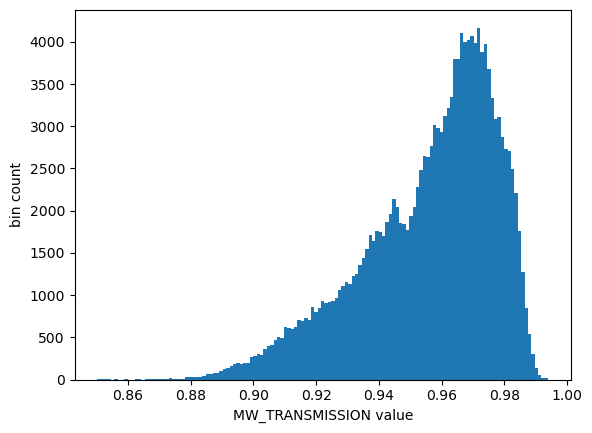

In [15]:
plt.hist(MW_TRANSMISSION_r, bins = "auto")
plt.xlabel("MW_TRANSMISSION value")
plt.ylabel("bin count")
plt.show()

In [16]:
# calculate the apparent magnitude of every galaxy

app_mag_z = gs.app_mag(ztile_cat["FLUX_Z"], mw_transmission = MW_TRANSMISSION_z)
app_mag_r = gs.app_mag(ztile_cat["FLUX_R"], mw_transmission = MW_TRANSMISSION_r)
app_mag_g = gs.app_mag(ztile_cat["FLUX_G"], mw_transmission = MW_TRANSMISSION_g)

In [17]:
# calculate the absolute magnitude of every galaxy, not yet including a K-correction however with SDSS filters (Planck Cosmology)

### NO K-CORRECTION USED; SHOULD BE ABLE TO IMPLEMENT QUICKLY
abs_mag_z = gs.abs_mag(app_mag_z, ztile_cat["Z"], "z", "g - z", app_mag_g - app_mag_z)
abs_mag_r = gs.abs_mag(app_mag_r, ztile_cat["Z"], "r", "g - r", app_mag_g - app_mag_r)

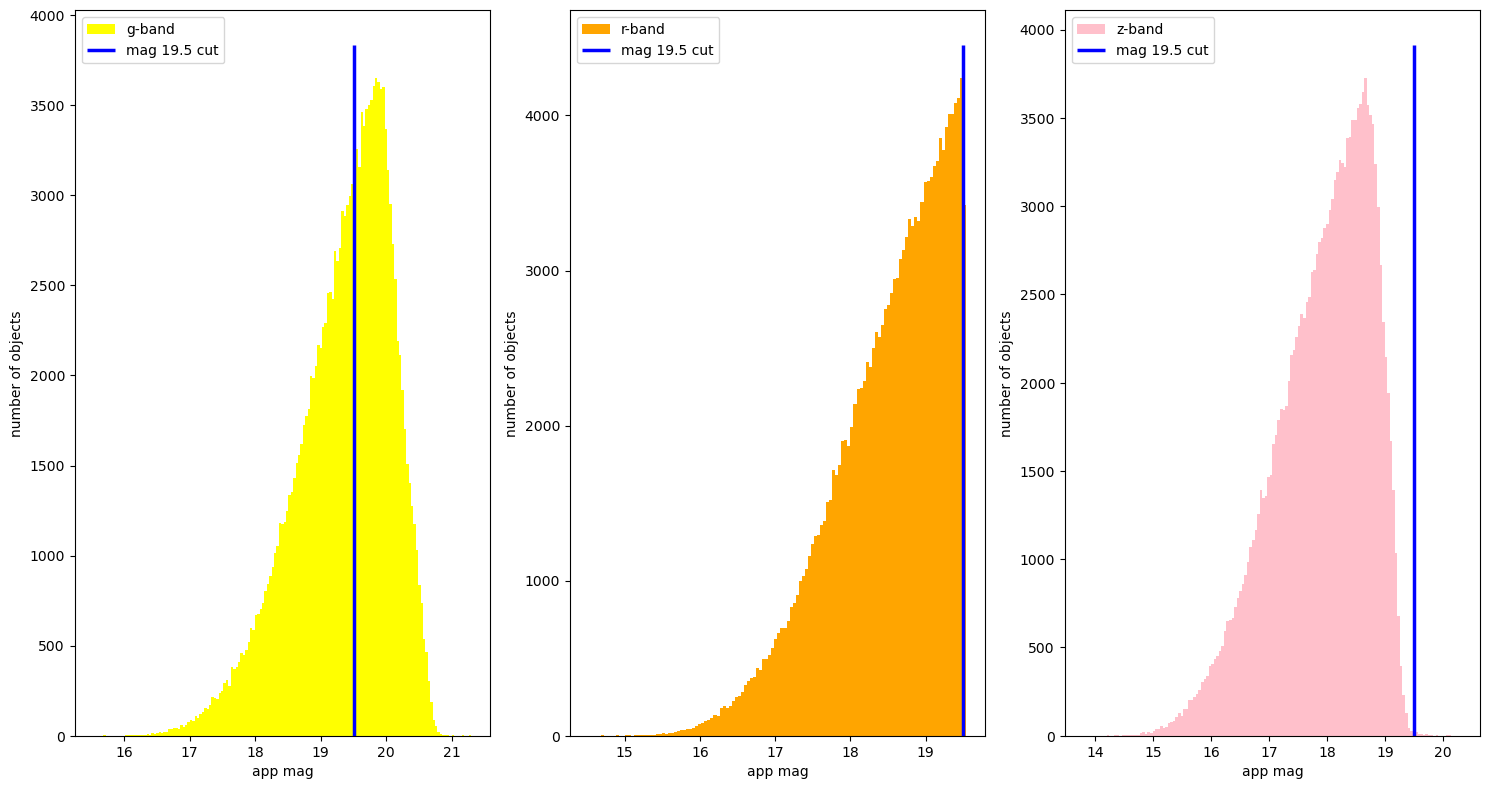

In [18]:
# plot magnitudes

fig, ax = plt.subplots(ncols = 3, figsize  = (15,8))


ax[0].hist(app_mag_g, bins = "auto", label = "g-band", color = "yellow")
ax[1].hist(app_mag_r, bins = "auto", label = "r-band", color = "orange")
ax[2].hist(app_mag_z, bins = "auto", label = "z-band", color = "pink")

ymin,ymax = ax[0].get_ylim()
for axis in ax:
    ymin,ymax = axis.get_ylim()
    axis.vlines(19.5, ymin, ymax, color = "blue", linewidth = 2.5, label = "mag 19.5 cut")
    axis.set_xlabel("app mag")
    axis.set_ylabel("number of objects")
    axis.legend(loc = "upper left")

plt.tight_layout()
plt.show()


### Compare the colors

In [19]:
corner_plot_data = {"G": app_mag_g, "R": app_mag_r, "Z": app_mag_z}
corner_plot_data = az.from_dict(posterior = corner_plot_data, sample_stats={"diverging": app_mag_r>19.5})

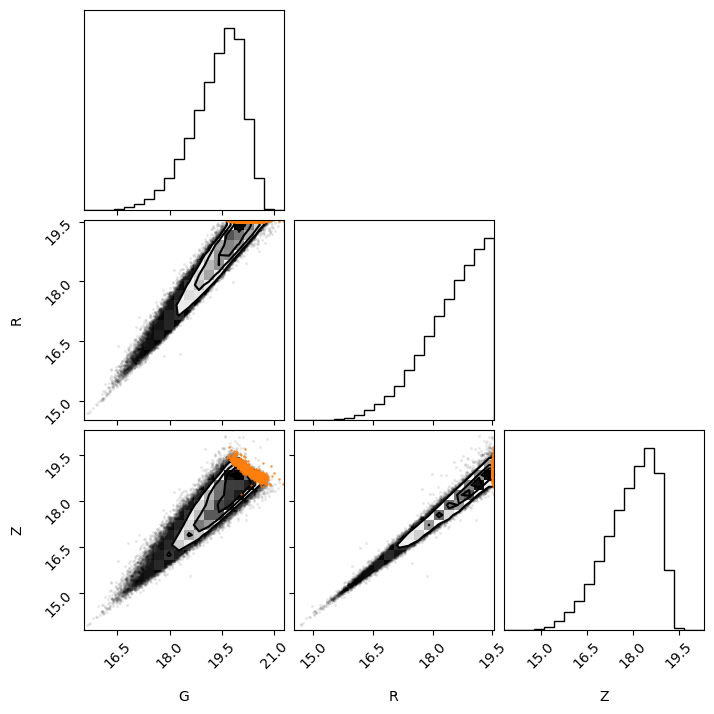

In [20]:
figure = corner.corner(corner_plot_data, divergences = True)

In [21]:
diff = [app_mag_r[q]-app_mag_z[q] for q in range(len(app_mag_r))]

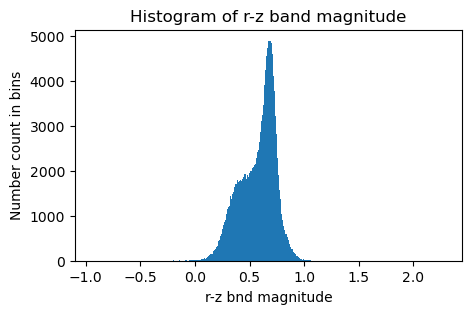

In [22]:
fig, ax = plt.subplots(figsize = (5,3))

ax.hist(diff, bins='auto')
ax.set_xlabel("r-z bnd magnitude")
ax.set_ylabel("Number count in bins")
plt.title("Histogram of r-z band magnitude")
plt.show()

In [23]:
avg_diff = np.mean(diff)

In [24]:
avg_diff

0.5754559689711256

### Calculate luminosities and add all the data to the table
We also then define the magnitude limit for the r-band, which is in the case of BGS Bright a clear m<19.5 cut

Then sort by app magnitude in r-band

In [25]:
lums_r = gs.lum(abs_mag_r, band = "r")

In [26]:
m_limit_r = 19.5

In [27]:
ztile_cat = hstack([ztile_cat, Table({"MW_TRANSMISSION_G": MW_TRANSMISSION_g}), Table({"MW_TRANSMISSION_R": MW_TRANSMISSION_r}), Table({"MW_TRANSMISSION_Z": MW_TRANSMISSION_z}), Table({"APP_MAG_G": app_mag_g}),  Table({"APP_MAG_R": app_mag_r}), Table({'APP_MAG_Z': app_mag_z}), Table({'ABS_MAG_R': abs_mag_r}), Table({"LUM_R": lums_r})])


In [28]:
# take a look at the data table
ztile_cat

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,LUM_R
,,,,,,,,,,,,,,,,,,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39628481163690801,210.00297557756,30.0018511912413,20230319,0.147265851065133,7.4364967849403e-06,0,14.7018299102783,23.1497573852539,32.0197525024414,GALAXY,131074,0.0122371269389987,1.73967480659485,0.963945712900877,0.9757730176571993,0.9865771984368094,19.541702955522247,19.062005902099653,18.721782758037392,-20.231477581800352,6.674593103696747e+35
39628481163691077,210.019712252076,30.0780974679947,20230319,0.109962347331243,1.29556967505809e-05,0,15.5349826812744,24.8674926757812,38.4654846191406,GALAXY,131074,0.0144533785060048,0.610406935214996,0.9575563863841603,0.9714484940146945,0.984165551965143,19.47463395925085,18.979469451618193,18.51999237817197,-19.628200974657133,3.829253804722014e+35
39628481163691092,210.020357945222,30.092709249839,20230402,0.146660718934836,2.35824592679098e-05,0,75.7559432983398,151.81005859375,246.94108581543,GALAXY,131074,0.01477609295398,3.65472197532654,0.9566295581343927,0.970820388911554,0.9838148775773772,17.753317713367892,17.01459585200611,16.500800080965163,-22.26913201115709,4.3600007817901927e+36
39628481163691220,210.029430444301,30.0055291830532,20230402,0.109417035366972,5.65207288427875e-06,0,9.63973426818848,15.9258823394775,24.8230361938477,GALAXY,131074,0.0120340930297971,0.637734234333038,0.9645331754918182,0.976170154625107,0.9867984280204917,20.000630269469802,19.468555056488096,18.998433871171237,-19.127546563074322,2.414639984415722e+35
39628481163691360,210.039013414964,30.113236216447,20230402,0.107746685027154,2.01875890988739e-05,0,16.691349029541,35.3922004699707,59.1554412841797,GALAXY,131074,0.0146014373749495,1.0,0.9571310533904093,0.9711602738618433,0.9840046497785025,19.39619992032994,18.59595835916116,18.05250613050862,-19.96436503372368,5.21890962324538e+35
39628481163691393,210.041301313575,30.102212337463,20230319,0.109321821977478,2.61051475044601e-05,0,43.5662384033203,88.6043014526367,152.781967163086,GALAXY,131074,0.0144699234515429,1.53619384765625,0.9575088478618035,0.9714162824002658,0.9841475705280819,18.354981830157108,17.599876431586623,17.022470317931862,-20.994199656342545,1.3474529986195203e+36
39628481163691577,210.053398910827,30.0771069380849,20230319,0.147211719036494,4.1463425910529e-05,0,43.8126792907715,114.859153747559,216.536575317383,GALAXY,131074,0.0138619868084788,5.44828176498413,0.9592571805137158,0.972600585515372,0.9848085062122829,18.350838115629337,17.319422286235042,16.644551318276648,-21.973190035439007,3.319783613005551e+36
39628481163691660,210.058162185709,30.0734582377556,20230402,0.105011890216101,1.13827254147843e-05,0,13.4912528991699,21.0608997344971,29.0350761413574,GALAXY,131074,0.0137314992025495,0.731865644454956,0.9596328588141073,0.9728549726539851,0.984950427390739,19.63013206710973,19.161427956307143,18.82622850930289,-19.339170652292076,2.934283176220888e+35


### Cutoff in magnitude and look at distribution

In [29]:
ztile_cat_r_cut = ztile_cat

In [30]:
num_before_r_band_cutout = len(ztile_cat_r_cut)

In [31]:
ztile_cat_r_cut = ztile_cat[ztile_cat["APP_MAG_R"] < m_limit_r]
# this step should really only cut out very few objects

In [32]:
print(f"Cut out {num_before_r_band_cutout-len(ztile_cat_r_cut)} objects, now have {len(ztile_cat_r_cut)} targets left in the catalog")

Cut out 3354 objects, now have 154636 targets left in the catalog


In [33]:
z_max_data = np.max(ztile_cat_r_cut["Z"])
z_min_data = np.min(ztile_cat_r_cut["Z"])
print("z min and max in sample: ", z_min_data, z_max_data)

z min and max in sample:  0.100001466606648 0.199999718050522


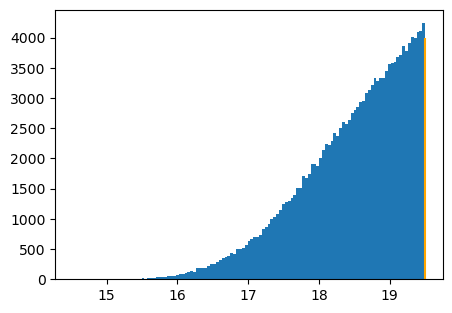

In [34]:
fig, ax = plt.subplots(figsize = (5,3.5))

ax.hist(ztile_cat_r_cut["APP_MAG_R"], bins = "auto")
ax.vlines(m_limit_r, 0, 4000, color = "orange")

plt.show()

### Sort data and take a look at luminosity limits & define function that calcs the distance to which objects of certain luminosity would be in BGS Bright

In [35]:
# first we group by app magnitude
ztile_cat_grouped_by_AppMag = ztile_cat_r_cut.group_by("APP_MAG_R")

# reverse the order
ztile_cat_grouped_by_AppMag = ztile_cat_grouped_by_AppMag[::-1]

In [36]:
# now lets check the data
ztile_cat_grouped_by_AppMag

# this data should now be sorted by the apparent magnitude in r-band in an descending order (i.e. brighter objects to the bottom)

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,LUM_R
,,,,,,,,,,,,,,,,,,,,,W
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.405248625368532,7.833091737508992e+35
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.58689492230129,3.6863089577909326e+35
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.553332819350562,3.5741015712345386e+35
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.60095745931228,3.734364848710018e+35
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.489044960807497,8.461585497559896e+35
39633096122828999,243.606491187989,41.0201731749984,20230407,0.138279626857195,6.60093458752409e-06,0,9.84133625030518,15.5370311737061,21.5276794433594,GALAXY,514,0.00994677282869816,1.0,0.9705934711742449,0.9802623644257126,0.9890756901495632,19.984958237473073,19.499935729543107,19.155580774459676,-19.64466322045568,3.887756452684687e+35
39633021174809872,265.700910976159,36.969156700567,20220522,0.173815876395162,1.4096968998993e-05,0,7.55792856216431,14.9376420974731,23.9784870147705,GALAXY,514,0.0295792277902365,1.0,0.915065855137738,0.9424411491013431,0.9678628097339647,20.207623919279396,19.49993047625399,19.014980064171144,-20.188554674671995,6.415871137061393e+35
39633025922764648,260.111165559501,37.2444580191916,20230407,0.134988139827934,1.25349726807455e-05,0,8.86761474609375,14.2990570068359,20.3584156036377,GALAXY,514,0.0513797178864479,0.764231622219086,0.8571206367235538,0.9021507064691104,0.9448400355898456,19.963087836851592,19.49992923990724,19.16653577836692,-19.587862355743816,3.689595067123553e+35


In [37]:
# this will be needed later on, maybe put it there then?
min_redshift_data = np.min(ztile_cat_grouped_by_AppMag["Z"]) # np.min(faint_mags["Z"]) # get the limits of redshift in this sample
max_redshift_data = np.max(ztile_cat_grouped_by_AppMag["Z"]) # np.max(faint_mags["Z"])

Simply for illustration purposes I will plot the apparent magnitudes of each galaxy and its corresponding redshift. Additionally, this plot includes the theoretical maximum limit of BGS Bright. Ideally, the limiting line is at the very bottom of the data...

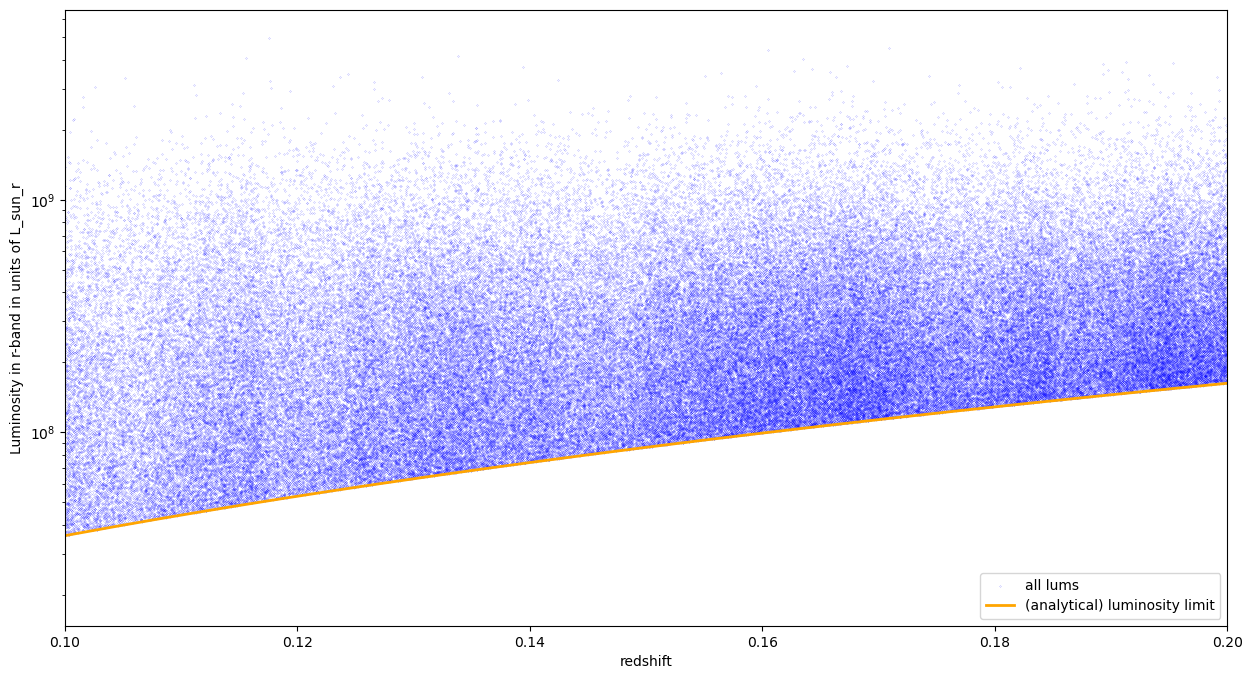

In [38]:
# create the plotting data: distances, luminosities at these distances and the corresponding redshifts assuming Planck18 cosmology
plot_distances = np.linspace(3500*10**5,1500*10**6, 500) # distances in pc
lum_lim_from_mag_lim = gs.lum(gs.abs_mag_ldist(19.5, plot_distances), band = "r")
z_from_dist = z_at_value(Planck18.luminosity_distance, plot_distances/(10**6)*u.Mpc, zmax = 1)

# plotting
fig, ax = plt.subplots(figsize = (15,8))

# plot all data and 20% lowest luminosity
ax.scatter(ztile_cat_grouped_by_AppMag["Z"], ztile_cat_grouped_by_AppMag["LUM_R"]/gs.L_sun_r, s = 0.01, color = "blue", label = "all lums")

# plot the luminosity limits
ax.plot(z_from_dist, lum_lim_from_mag_lim/gs.L_sun_r, linewidth = 2, color = "orange", label = "(analytical) luminosity limit")

# set labels,...
ax.set_xlabel("redshift")
ax.set_ylabel("Luminosity in r-band in units of L_sun_r")
ax.set_yscale("log")
ax.set_xlim(min_redshift, max_redshift)
#ax.set_ylim(3*10**7,1*10**9)
ax.legend(loc = "lower right")
plt.show()

In [39]:
def dist_from_lum_limit(lum, m_limit):
    return np.sqrt(lum/gs.L_sun_r)*10**(0.2*m_limit_r+1)*u.Mpc/(10**6)

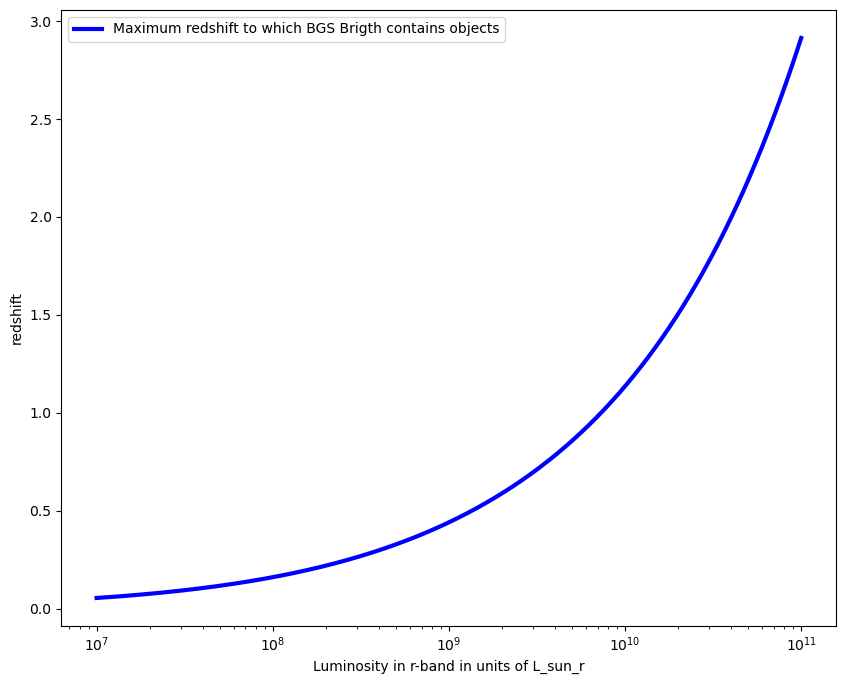

In [40]:
# now plot the inverse:

fig, ax = plt.subplots(figsize = (10,8))

# define the range in which we want to plot
plot_lums = np.logspace(np.log10(10**7*gs.L_sun_r), np.log10(10**11*gs.L_sun_r), 1000, endpoint = True)

# get the distances corresponding to the above created luminosites and from there calculate the redshifts in Planck18 cosmology
# derived a theoretical expression for this (see notability)
d_pc = dist_from_lum_limit(plot_lums, m_limit_r)
z_from_some_lums_r = z_at_value(Planck18.luminosity_distance, d_pc, zmin= 0.01, zmax = 20)

# plot the data
ax.plot(plot_lums/gs.L_sun_r, z_from_some_lums_r, linewidth = 3, color = "blue", label = "Maximum redshift to which BGS Brigth contains objects")

ax.set_xlabel("Luminosity in r-band in units of L_sun_r")
ax.set_ylabel("redshift")
ax.set_xscale("log")
ax.legend()
plt.show()

## Correct the Malmquist bias & fit schechter function (abs mag) to data

We have now defined our analytical function above, which tells us to which distance we can detect a galaxy. We now do the following:
- Calculate this distance for every object in the sample and add to the table
- Calc the V_max value for each galaxy
- calculate the 1/V_max values and add them together in bins
- calculate the phi_j values (these are then of course in bins as above)
- calculate the according errors

### Step 1: distance for every object

In [41]:
dist_max_i = dist_from_lum_limit(ztile_cat_grouped_by_AppMag["LUM_R"], m_limit_r)/u.W

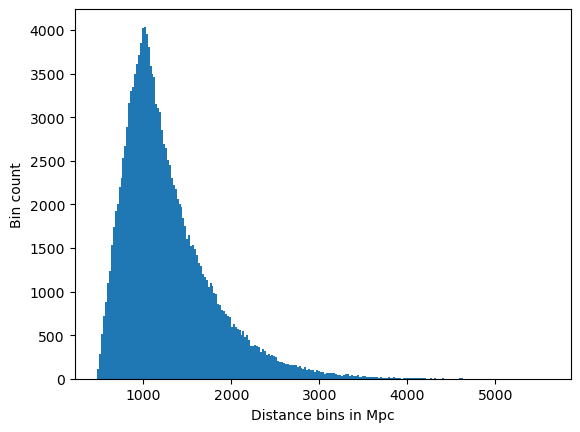

In [42]:
# quickly have a look at the distance ditribution
plt.hist(dist_max_i, bins = "auto")
plt.xlabel("Distance bins in Mpc")
plt.ylabel("Bin count")
plt.show()

In [43]:
ztile_cat_z_max = hstack([ztile_cat_grouped_by_AppMag, Table({"dist_max": dist_max_i})])

In [44]:
ztile_cat_z_max[:5]

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,LUM_R,dist_max
,,,,,,,,,,,,,,,,,,,,,W,Mpc
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.405248625368532,7.833091737508992e+35,957.3036726659116
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.58689492230129,3.6863089577909326e+35,656.7180974145708
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.553332819350562,3.5741015712345386e+35,646.6459529425589
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.60095745931228,3.734364848710018e+35,660.9848293644262
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.489044960807497,8.461585497559896e+35,994.9677225603458


In [45]:
dist_min_data, dist_max_data = Distance(z = np.min(ztile_cat_z_max["Z"]), cosmology = Planck18), Distance(z = np.max(ztile_cat_z_max["Z"]), cosmology = Planck18)
print(f"The minimal distance in our dataset is {dist_min_data}Mpc, while the maximum distance is {dist_max_data}Mpc (Planck18 cosmology)")

The minimal distance in our dataset is 475.8297081554395 MpcMpc, while the maximum distance is 1012.2918878420452 MpcMpc (Planck18 cosmology)


### Step 2: get the V_max_i values

In [46]:
# calculate the actual V_max values
V_max_dist_i = gs.V_max_dist(area, dist_min_data, dist_max_data, ztile_cat_z_max["dist_max"])

In [48]:
# add them to the data table
ztile_wVmax = hstack([ztile_cat_z_max, Table({"V_MAX_DIST": V_max_dist_i})])

In [49]:
ztile_wVmax

TARGETID,TARGET_RA,TARGET_DEC,LASTNIGHT,Z,ZERR,ZWARN,FLUX_G,FLUX_R,FLUX_Z,SPECTYPE,BGS_TARGET,EBV,SERSIC,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,APP_MAG_G,APP_MAG_R,APP_MAG_Z,ABS_MAG_R,LUM_R,dist_max,V_MAX_DIST
,,,,,,,,,,,,,,,,,,,,,W,Mpc,Mpc3
int64,float64,float64,int64,float64,float64,int64,float64,float64,float64,bytes6,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
39633030595219808,249.733631644974,37.4732991549371,20230407,0.190212097732953,1.56199338241144e-05,0,8.20665836334229,15.3824548721313,23.3471660614014,GALAXY,514,0.0149062499403954,1.0,0.9562560042706568,0.9705671769012062,0.9836734791685573,20.16601955152961,19.499999875974634,19.061541975499654,-20.405248625368532,7.833091737508992e+35,957.3036726659116,55634997.90226415
39633109762703891,244.161322331921,41.6303271093301,20230413,0.134936473140002,1.33186726712494e-05,0,8.08626842498779,15.5909690856934,26.2269706726074,GALAXY,514,0.00819051265716553,4.0,0.9757220597412367,0.9837188146026058,0.9909958370812224,20.203944925481743,19.49999466843444,18.94330924878598,-19.58689492230129,3.6863089577909326e+35,656.7180974145708,12687137.15513905
39632936244349812,224.717818631139,32.8047872328327,20210617,0.133025712157617,6.50324250296245e-06,0,6.07890319824219,15.3306283950806,30.5596485137939,GALAXY,514,0.0166043099015951,1.81494736671448,0.9513958733216881,0.9672697558455311,0.9818306218303785,20.48634008923794,19.49996912980151,18.767220545348636,-19.553332819350562,3.5741015712345386e+35,646.6459529425589,11759400.736299288
39633006553465242,261.054461427447,36.3126715149904,20210620,0.135741935573797,1.07250894751914e-05,0,7.22450590133667,14.4356489181519,26.1014652252197,GALAXY,514,0.0466230884194374,0.5,0.8694423511725651,0.910792118560344,0.9498161872888674,20.20108160252782,19.499957381430473,18.90243669831692,-19.60095745931228,3.734364848710018e+35,660.9848293644262,13088830.315019544
39633030435834075,237.682160486113,37.4391214009135,20220611,0.196921017875486,1.45044040786855e-05,0,5.97568941116333,15.3868093490601,29.309850692749,GALAXY,514,0.0147932274267077,2.283198595047,0.9565803734220804,0.9707870511260926,0.9837962620696988,20.510833623130537,19.499938505434933,18.8147289050518,-20.489044960807497,8.461585497559896e+35,994.9677225603458,63419374.06371026
39633096122828999,243.606491187989,41.0201731749984,20230407,0.138279626857195,6.60093458752409e-06,0,9.84133625030518,15.5370311737061,21.5276794433594,GALAXY,514,0.00994677282869816,1.0,0.9705934711742449,0.9802623644257126,0.9890756901495632,19.984958237473073,19.499935729543107,19.155580774459676,-19.64466322045568,3.887756452684687e+35,674.4234214290504,14388278.835599815
39633021174809872,265.700910976159,36.969156700567,20220522,0.173815876395162,1.4096968998993e-05,0,7.55792856216431,14.9376420974731,23.9784870147705,GALAXY,514,0.0295792277902365,1.0,0.915065855137738,0.9424411491013431,0.9678628097339647,20.207623919279396,19.49993047625399,19.014980064171144,-20.188554674671995,6.415871137061393e+35,866.385020609593,39226206.522589654
39633025922764648,260.111165559501,37.2444580191916,20230407,0.134988139827934,1.25349726807455e-05,0,8.86761474609375,14.2990570068359,20.3584156036377,GALAXY,514,0.0513797178864479,0.764231622219086,0.8571206367235538,0.9021507064691104,0.9448400355898456,19.963087836851592,19.49992923990724,19.16653577836692,-19.587862355743816,3.689595067123553e+35,657.0107433603317,12714522.39349239


### Step 3+4: Calc the 1/V_max values, sum them up in bins

In [52]:
min_mag_data = np.min(ztile_wVmax["ABS_MAG_R"])
max_mag_data = np.max(ztile_wVmax["ABS_MAG_R"])
print(f"lower and upper limit of absolute magnitude (r-band): {min_mag_data} and {max_mag_data}")

abs_mag_bin_edges = np.arange(min_mag_data, max_mag_data, 1)

lower and upper limit of absolute magnitude (r-band): -24.241778371331545 and -18.891889731382207


In [53]:
def calc_phi_j_dist(V_max_i, lum_bins, w_spec = 1):
    
    phi_j = [0 for q in range(len(abs_mag_bin_edges)-1)]
    cnt = 0
    for q in range(len(phi_j)):
        
        ii = ztile_wVmax["ABS_MAG_R"] >= abs_mag_bin_edges[q]
        ii &= ztile_wVmax["ABS_MAG_R"]< abs_mag_bin_edges[q+1]
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX_DIST"]
        one_ov_dat = [w_spec/vmax for vmax in dat]
        phi_j[cnt] = np.sum(one_ov_dat)
        cnt += 1
    return phi_j

In [55]:
phi_j_dist = calc_phi_j_dist(V_max_dist_i, abs_mag_bin_edges)

### Step 5: Calculate the errors

Here we follow the approach of Weigel et al. (page 7) and assume that we are in the limit case, where we have large N and therefore we us:

$$\sigma = W_{eff} \cdot \sqrt{N_{eff}} = \sqrt{\sum_i^{N_{bin}}\frac{w_{spec,i}^2}{V_{max,i}^2}}$$

In [76]:
def calc_phi_j_sigma(abs_mag_bin_edges, w_spec = 1):
    phi_j_sigma = [0 for q in range(len(abs_mag_bin_edges)-1)]
    cnt = 0
    #print(lum_bins)
    for q in range(len(phi_j_sigma)):
        
        ii = ztile_wVmax["ABS_MAG_R"] >= abs_mag_bin_edges[q]
        ii &= ztile_wVmax["ABS_MAG_R"]< abs_mag_bin_edges[q+1]
        #print(np.min(ii))
        dat = ztile_wVmax[ii]
        print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX_DIST"]
        #print(f"dat: {dat}")
        one_ov_dat = [w_spec**2/vmax**2 for vmax in dat]
        phi_j_sigma[cnt] = np.sqrt(np.sum(one_ov_dat))
        cnt += 1
    return phi_j_sigma

def calc_W_eff(abs_mag_bin_edges, w_spec = 1):
    W_eff = [0 for q in range(len(abs_mag_bin_edges)-1)]
    cnt = 0
    #print(lum_bins)
    for q in range(len(W_eff)):
        
        ii = ztile_wVmax["ABS_MAG_R"] >= abs_mag_bin_edges[q]
        ii &= ztile_wVmax["ABS_MAG_R"]< abs_mag_bin_edges[q+1]
        #print(np.min(ii))
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX_DIST"]
        #print(f"dat: {dat}")
        one_ov_sqr_dat = [w_spec**2/vmax**2 for vmax in dat]
        one_ov_dat = [w_spec/vmax for vmax in dat]
        W_eff[cnt] = np.sum(one_ov_sqr_dat)/np.sum(one_ov_dat)
        cnt += 1
    return W_eff

def calc_N_eff(W_eff, abs_mag_bin_edges, w_spec = 1):
    N_eff = [0 for q in range(len(abs_mag_bin_edges)-1)]
    cnt = 0
    #print(lum_bins)
    for q in range(len(N_eff)):
        
        ii = ztile_wVmax["ABS_MAG_R"] >= abs_mag_bin_edges[q]
        ii &= ztile_wVmax["ABS_MAG_R"]< abs_mag_bin_edges[q+1]
        #print(np.min(ii))
        dat = ztile_wVmax[ii]
        #print("Num of objects in this bin", len(dat))
        dat = dat["V_MAX_DIST"]
        #print(f"dat: {dat}")
        one_ov_dat = [w_spec/vmax for vmax in dat]
        N_eff[cnt] = np.sum(one_ov_dat)/W_eff[q]
        cnt += 1
    return N_eff

def calc_phi_j_sigma_uplow(phi_j, W_eff, N_eff):
    # approximations from https://articles.adsabs.harvard.edu/pdf/1986ApJ...303..336G, S = 1 as in WEigel paper
    phi_j = np.array(phi_j)
    lambda_up = N_eff+np.sqrt(np.array(N_eff)+0.75)+1
    lambda_low = N_eff - np.sqrt(np.array(N_eff) - 0.25)
    sigma_up = abs(-phi_j+W_eff*lambda_up)
    sigma_low = abs(phi_j-W_eff*lambda_low)
    return list(zip(sigma_low, sigma_up))

In [90]:
W_eff = calc_W_eff(abs_mag_bin_edges, w_spec = 1)
N_eff = calc_N_eff(W_eff, abs_mag_bin_edges, w_spec = 1)
y_err_uplow = np.array(calc_phi_j_sigma_uplow(phi_j_dist, W_eff, N_eff))

In [79]:
phi_j_sigma = np.array(calc_phi_j_sigma(abs_mag_bin_edges, w_spec = 1))

Num of objects in this bin 367
Num of objects in this bin 8338
Num of objects in this bin 38634
Num of objects in this bin 73885
Num of objects in this bin 31952


In [56]:
center_abs_mag_bins = abs_mag_bin_edges[1:]-(abs_mag_bin_edges[2]-abs_mag_bin_edges[1])/2

### Perform the fit and plot it

In [308]:
Schechter = models.Schechter1D(phi_star = 0.0010, m_star = -21, alpha = -1.1)
# set fitting algorithm
fit_alg = fitting.LMLSQFitter() # only this Fitter is able to fit, all others from here: https://docs.astropy.org/en/stable/modeling/fitting.html fail
# perform fit


schechter_fit_analytical = fit_alg(Schechter, center_abs_mag_bins, phi_j_dist, weights = 1/2*phi_j_sigma)

print(schechter_fit_analytical)

cov_diag = np.diag(fit_alg.fit_info["param_cov"])
print("-------------------------------------------------------------------")
print(f"phi_star std: {cov_diag[0]}")
print(f"m_star std: {cov_diag[1]}")
print(f"alpha std: {cov_diag[2]}")


Model: Schechter1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
           phi_star              m_star              alpha       
    --------------------- ------------------- -------------------
    0.0016745140734036254 -21.757361746831197 -1.1297780395774693
-------------------------------------------------------------------
phi_star std: 6.461031512656688e-10
m_star std: 0.0003381499974566563
alpha std: 3.226145579464074e-05


In [309]:
plt_sigma = 3

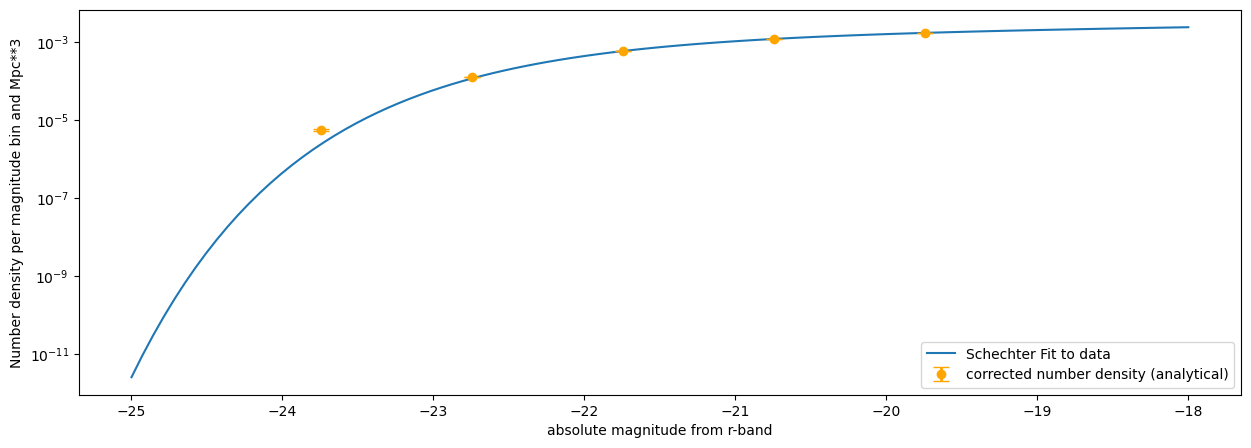

In [310]:
fig, ax = plt.subplots(figsize = (15,5))

plot_abs_mags = np.linspace(-25, -18, 100)

# I am not actually plotting the min and max fit, since it indistinguishible...
schechter_max = Schechter1D(schechter_fit_analytical.phi_star.value+plt_sigma*cov_diag[0], schechter_fit_analytical.m_star.value-plt_sigma*cov_diag[1], schechter_fit_analytical.alpha.value+plt_sigma*cov_diag[2])
schechter_min = Schechter1D(schechter_fit_analytical.phi_star.value-plt_sigma*cov_diag[0], schechter_fit_analytical.m_star.value+plt_sigma*cov_diag[1], schechter_fit_analytical.alpha.value-plt_sigma*cov_diag[2])

ax.plot(plot_abs_mags, schechter_fit_analytical(plot_abs_mags), label = f"Schechter Fit to data")
# ax.plot(plot_abs_mags, schechter_min(plot_abs_mags), color = "red", linestyle = "dotted")
# ax.plot(plot_abs_mags, schechter_max(plot_abs_mags), color = "green", linestyle = "dotted")

ax.errorbar(center_abs_mag_bins, phi_j_dist, phi_j_sigma, color = "orange", label = "corrected number density (analytical)", fmt = "o", linewidth=2, capsize=6)

#ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("absolute magnitude from r-band")
ax.set_ylabel("Number density per magnitude bin and Mpc**3")

plt.legend(loc = "lower right")
#plt.savefig("NumberDensity-1_overVmax.png", dpi = 300, transparent = True)

plt.show()

## Get the luminosity schechter function & plot it

Since there is a clear mathematical connection between the magnitudes and luminosities we can simply convert the functions (see notability for algebra).

For the errors I am now simply using the uncertainties package to save some time. Generally, the uncertainties package uses gaussian error propagation for its error calculation.

In [316]:
# define schecher luminosity function
def schechter_lum(L, phi_star, L_star, alpha):
    return phi_star*(L/L_star)**(alpha)*unumpy.exp(-L/L_star)

In [312]:
# calculate the luminosities corresponding to the above magnitudes
center_lum_bins = gs.lum(center_abs_mag_bins, band = "r")

In [317]:
# get the values from above including their errors in a ufloat variable
phi_star = unc.ufloat(schechter_fit_analytical.phi_star.value, cov_diag[0])
m_star = unc.ufloat(schechter_fit_analytical.m_star.value, cov_diag[1])
alpha = unc.ufloat(schechter_fit_analytical.alpha.value, cov_diag[2])

In [314]:
# get the values for the schechter luminosity function from the absolute magnitude function above (see notability for algebra)
L_star, L_phi_star, L_alpha = gs.L_sun_r*10**(-0.4*m_star), phi_star*0.4*um.log(10), alpha+1
analytical_L_schechter = [L_phi_star.n, L_star.n, L_alpha.n]
analytical_L_schechter_max = [L_phi_star.n+plt_sigma*L_phi_star.s, L_star.n+plt_sigma*L_star.s, L_alpha.n-plt_sigma*L_alpha.s]
analytical_L_schechter_min = [L_phi_star.n-plt_sigma*L_phi_star.s, L_star.n-plt_sigma*L_star.s, L_alpha.n+plt_sigma*L_alpha.s]

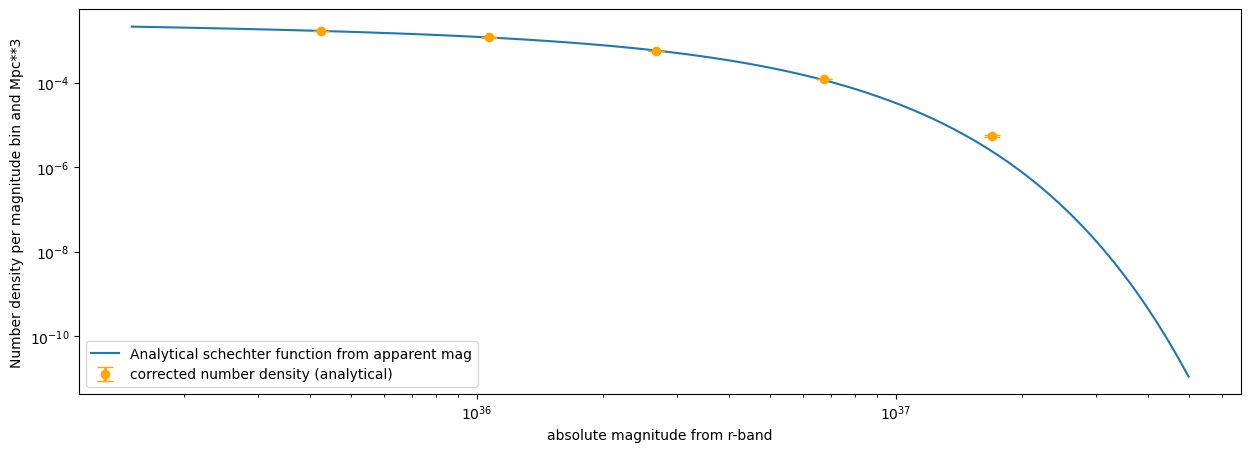

In [315]:
# plot the luminosity schechter function

fig, ax = plt.subplots(figsize = (15,5))

plot_lums = np.logspace(np.log10(1.5*10**35), np.log10(0.5*10**38), 100)

ax.plot(plot_lums, schechter_lum(plot_lums, *analytical_L_schechter), label = f"Analytical schechter function from apparent mag")

# again I do not plot the min/max function since both overlap exactly on the original function, even for the 3sigma interval
# ax.plot(plot_lums, schechter_lum(plot_lums, *analytical_L_schechter_max), label = "max", color = "green", linestyle = "dashed")
# ax.plot(plot_lums, schechter_lum(plot_lums, *analytical_L_schechter_min), label = "min", color = "red", linestyle = "dotted")

ax.errorbar(center_lum_bins, phi_j_dist, phi_j_sigma, color = "orange", label = "corrected number density (analytical)", fmt = "o", linewidth=2, capsize=6)

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("absolute magnitude from r-band")
ax.set_ylabel("Number density per magnitude bin and Mpc**3")

plt.legend(loc = "lower left")
#plt.savefig("NumberDensity-1_overVmax.png", dpi = 300, transparent = True)

plt.show()